In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))


import warnings
warnings.filterwarnings('ignore')

['test', 'train', 'train.csv', 'sample_submission.csv']



## Data import

In [2]:
train = pd.read_csv("../input/train.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
Image    25361 non-null object
Id       25361 non-null object
dtypes: object(2)
memory usage: 396.3+ KB


In [4]:
train.shape

(25361, 2)

In [5]:
train.Id.describe()

count         25361
unique         5005
top       new_whale
freq           9664
Name: Id, dtype: object

In [6]:
train.head(10)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [7]:
train.tail(10)

,Image,Id
25351,ffd61cded.jpg,new_whale
25352,ffd7a6f5a.jpg,w_84c23bb
25353,ffdddcc0f.jpg,new_whale
25354,ffe52d320.jpg,w_bc285a6
25355,ffe7560cd.jpg,w_6d8b67b
25356,ffef89eed.jpg,w_9c506f6
25357,fff7faf61.jpg,w_9cf0388
25358,fff9002e0.jpg,w_bd1c3d5
25359,fffcde6fe.jpg,w_9f30885
25360,fffde072b.jpg,new_whale


In [8]:
# put labels into y_train variable
y_train = train["Id"]

X_train = train.drop(labels = ["Id"], axis = 1)
y_train.head()

0    w_f48451c
1    w_c3d896a
2    w_20df2c5
3    new_whale
4    new_whale
Name: Id, dtype: object


## Image preprocessing

In [10]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

def prepareImages(train, shape, path):
    
    x_train = np.zeros((shape, 100, 100, 3))
    count = 0
    
    for fig in train['Image']:
        
        #load images into images of size 100x100x3
        img = image.load_img("../input/"+path+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        x_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return x_train

Using TensorFlow backend.


In [11]:
x_train = prepareImages(train, train.shape[0], "train")

Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg
Processing image


### Data normalization

In [12]:
x_train = x_train / 255.0
print("x_train shape: ",x_train.shape)

x_train shape:  (25361, 100, 100, 3)


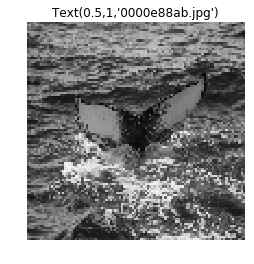

In [13]:
plt.imshow(x_train[0][:,:,0], cmap="gray")
plt.title(plt.title(train.iloc[0,0]))
plt.axis("off")
plt.show()

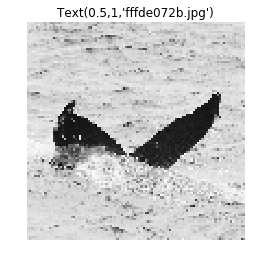

In [14]:
# example
plt.imshow(x_train[25360][:,:,0], cmap="gray")
plt.title(plt.title(train.iloc[25360,0]))
plt.axis("off")
plt.show()


## Label Encoder

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [17]:
y_train = label_encoder.fit_transform(y_train)

In [18]:
#First 10 values
y_train[0:10]

array([4786, 3808,  662,    0,    0,    0, 4315,    0, 1929, 3237])

In [19]:
y_train.shape

(25361,)

In [20]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 5005)

In [21]:
print(y_train.shape)
y_train

(25361, 5005)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)


## Keras

In [22]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential # cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation = "softmax"))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
__________

### Optimizer and Annealer

In [24]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [25]:
# optimizer = RMSprop(lr = 0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


### Model Compilation

In [27]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

<a id="9"></a>
### Data Augmentation

In [29]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation:

* > Randomly rotate some training images by 10 degrees **
* > Randomly zoom by 10% some training images **
* > Randomly shift images horizontally by 10% of the width **
* > Randomly shift images vertically by 10% of the height **


### Epochs and Batch Size

In [30]:
epochs = 100
batch_size = 1000


### Fitting the Model

In [2]:

# history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[learning_rate_reduction])

In [32]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=100, verbose = 2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction]) 


### Model evaluation


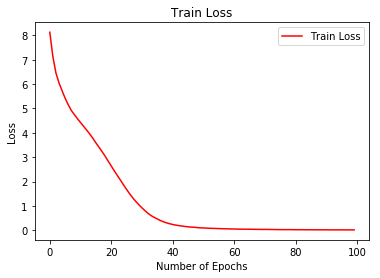

In [33]:
# Plots
plt.plot(history.history['loss'], color='r', label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

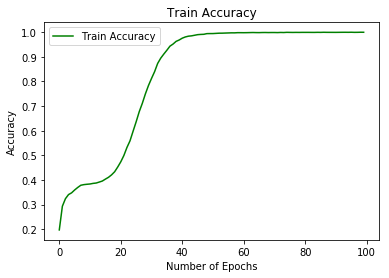

In [34]:
plt.plot(history.history['acc'], color='g', label="Train Accuracy")
plt.title("Train Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:
print('Train accuracy of the model: ',history.history['acc'][-1])

Train accuracy of the model:  0.9997239889329006


In [36]:
print('Train loss of the model: ',history.history['loss'][-1])

Train loss of the model:  0.01407919584265864


<a id="13"></a> <br>
## Predict Test Data

In [37]:
test = os.listdir("../input/test/")
print(len(test))

7960


In [38]:
col = ['Image']
test_data = pd.DataFrame(test, columns=col)
test_data['Id'] = ''

In [39]:
x_test = prepareImages(test_data, test_data.shape[0], "test")
x_test /= 255

Processing image:  1 ,  f97e5dda8.jpg
Processing image:  501 ,  cfeae6723.jpg
Processing image:  1001 ,  c970d4003.jpg
Processing image:  1501 ,  bfb9ef767.jpg
Processing image:  2001 ,  abfd5a81c.jpg
Processing image:  2501 ,  1a4b25e55.jpg
Processing image:  3001 ,  8685ae517.jpg
Processing image:  3501 ,  86a79254b.jpg
Processing image:  4001 ,  cef1ce25f.jpg
Processing image:  4501 ,  0fbe7a441.jpg
Processing image:  5001 ,  a9b4bef82.jpg
Processing image:  5501 ,  08af2949e.jpg
Processing image:  6001 ,  1bd524f66.jpg
Processing image:  6501 ,  4b4345266.jpg
Processing image:  7001 ,  11d369040.jpg
Processing image:  7501 ,  c85b4651a.jpg


In [40]:
predictions = model.predict(np.array(x_test), verbose=1)

7960/7960 [==============================] - 2s 312us/step
